# Bi-directional Search

The point of bidirectional search is to run two simultaneous, not parallel, search from the origin and destination node hoping that they would meet in the middle.  

**but** what is the point?  

Imagine that you are doing BFS with complexity in a graph with a constant branching factor $b$ and depth $d$ so the complexity would be $O({d}^b)$ but what if we split that depth $d$ in half (that usually doesn't happen) so the total complexity would be $O({(d/2)}^b) + O({(d/2)}^b)$ which is in total much lower than $O({d}^b)$.  

Let's see some pictures, sorry for the paint-level editing in advance.

This is a uni-directional breadth first search.

![title](./images/Uni-BFS.png)

This is bi-directional breadth first search

![title](./images/Bi-BFS.jpg)

As you can see how many (blue) nodes that didn't contribute to the solution didn't get expanded in the bi-driectional search, cutting complexity and consumed resources drastically.

__Bi_DIRECTIONAL_SEARCH__ ( _source_ , _destination_ ) __returns__ a route   

&emsp; // f stands for source/front expansion and b stands for destination/back expansion  

&emsp; _frontier\_f_ &larr; initialized with _source_  
&emsp; _frontier\_b_ &larr; initialized with _destination_  
&emsp; _explored\_f_ &larr; empty  
&emsp; _explored\_b_ &larr; empty  
&emsp; _collide_ &larr; _False_ &emsp;&emsp; // if front expansion overlapped with back expansion  
&emsp; _found_ &larr; _False_ &emsp;&emsp; // if we found the destination from a single expansion which if you think about it, will never happen  
&emsp; _altr\_expand_ &larr; _False_ &emsp;&emsp; // To alternate between expansion from front and back  

&emsp; __while__ _frontier\_f_ __is not__ empty __and__ _frontier\_b_ __is not__ empty __and__ __not__ _collide_ __and__ __not__ _found_ __do__  
&emsp;&emsp; __if__ _altr\_expand_ __then__  
&emsp;&emsp;&emsp; _node_ &larr; _frontier\_f_.pop()   
&emsp;&emsp;&emsp; __add__ _node_ __to__ _explored_f_  
&emsp;&emsp;&emsp; __for__ _child_ __in__ _node_.expand() __do__  
&emsp;&emsp;&emsp;&emsp; __if__ _child_ __in__ _explored\_f_ __then__ continue  
&emsp;&emsp;&emsp;&emsp; __if__ _child_ __is__ _destination_ __then__  
&emsp;&emsp;&emsp;&emsp;&emsp; _route_ &larr; _child_.route()  
&emsp;&emsp;&emsp;&emsp;&emsp; _found_ &larr; _True_  
&emsp;&emsp;&emsp;&emsp; __if__ _child_ __is in__ _explored_b_ __then__ &emsp;//overlapping -- met in the middle  
&emsp;&emsp;&emsp;&emsp;&emsp; _route_ &larr; _child_.route() + _overlapped_.route()  
&emsp;&emsp;&emsp;&emsp;&emsp; _collid_ &larr; _True_  
&emsp;&emsp;&emsp;&emsp; __add__ _child_ __to__ _frontier\_f_  
&emsp;&emsp; __else__  
&emsp;&emsp;&emsp; _node_ &larr;  _frontier\_b_.pop()  
&emsp;&emsp;&emsp; __add__ _node_ __to__ _explored\_b_  
&emsp;&emsp;&emsp; __for__ _child_ __in__ _node_.expand() __do__  
&emsp;&emsp;&emsp;&emsp; __if__ _child_ __in__ _explored\_b_ __then__ continue  
&emsp;&emsp;&emsp;&emsp; __if__ _child_ __is__ _destination_ __then__  
&emsp;&emsp;&emsp;&emsp;&emsp; _route_ &larr; _child_.route()  
&emsp;&emsp;&emsp;&emsp;&emsp; _found_ &larr; _True_  
&emsp;&emsp;&emsp;&emsp; __if__ _child_ __is in__ _explored_f_ __then__ &emsp;//overlapping -- met in the middle  
&emsp;&emsp;&emsp;&emsp;&emsp; _route_ &larr; _child_.route() + _overlapped_.route()  
&emsp;&emsp;&emsp;&emsp;&emsp; _collid_ &larr; _True_  
&emsp;&emsp;&emsp;&emsp; __add__ _child_ __to__ _frontier\_b_  
&emsp; __return__ _route_

# The Algorithm

In [ ]:
%%capture

##############################################################################
# IGNORE if you are running on a local machine and have all the dependencies #
##############################################################################

# installing dependencies --- to be able to run on google colab
# it would take 2-3 minutes
!apt-get install libspatialindex-c4v5;
!pip3 install Rtree;
!pip3 install osmnx;
!pip3 install tqdm;

# You need to upload Utilities.zip in /content directory which is the default
!unzip Utilities.zip

In [1]:
import osmnx as ox
import time, sys
from collections import deque
from tqdm import tqdm
from Utilities.utils import *

let's load our beloved UofT map

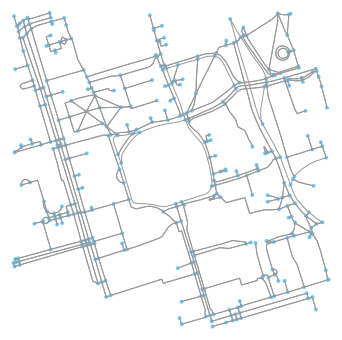

In [2]:
location_point = (43.661667, -79.395)
G = ox.graph_from_point(location_point, dist=300, clean_periphery=True, simplify=True)
graph_map = ox.plot_graph_folium(G, popup_attribute='name', edge_width=2)
fig, ax = ox.plot_graph(G)

Here you need to specify which node from our graph is the source (Equestrian Statue of Edward VII) and which is the destination node (Bahen Center of Technology). You can do so by acquiring the decimal coordinates of the desired node and use [```osmnx.distance.get_nearest_node```](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.distance.get_nearest_node) method

I used the aforementioned method and found that the nodes for destination and source are 389677909, 55808290 respectively

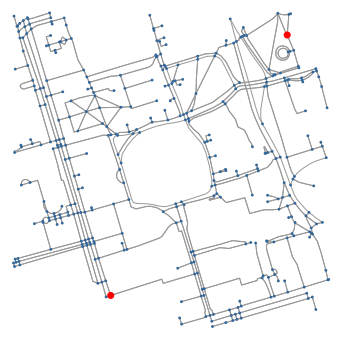

In [3]:
highlighted = [389677909, 55808290]

# marking both the source and destination node

nc = ['r' if node in highlighted else '#336699' for node in G.nodes()]
ns = [50 if node in highlighted else 8 for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_size=ns, node_color=nc, node_zorder=2)

In [4]:
draw_map(G, highlight = highlighted)

Map(center=[43.6618621, -79.3941032], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_titl…

In [5]:
%%capture
source(Node)

We are implementing A* based bi-directional search algorithm, so our criteria of expansion, either from source or destination, is the sum of staright line distance between a given node and the source and the distance between the node and the destination.  

Please note the following:  

1. the origin and destination for the expansion from destionation node are reversed
2. `f` stands for frontier (source expansion), `b` stands for back (destination expansion)


In [6]:
# first define the origin/source nodes as Node
origin = Node(graph = G, osmid = 55808290)
destination = Node(graph = G, osmid = 389677909)
destination_b = origin
origin_b = destination

In [7]:
toGoal_f, toDestination_f = astar_heuristic(G, 55808290, 389677909)
toGoal_b, toDestination_b = astar_heuristic(G, 389677909, 55808290)

In [8]:
%%time
route = []

# uncomment the following line to see the progress bar

bar = tqdm(total=len(G))

f_value = lambda node: toGoal_f[node.osmid] + toDestination_f[node.osmid]
b_value = lambda node: toGoal_b[node.osmid] + toDestination_b[node.osmid]

frontier_f = list()
frontier_b = list()

frontier_f.append(origin)
frontier_b.append(origin_b)

explored_f = list()
explored_b = list()

collide = False
found = False
altr_exapnd = False # to alternate between front and back

while frontier_f and frontier_b and not collide and not found:
    bar.update(1); time.sleep(0.05)
    
    if altr_exapnd:
        # remove node_f from frontier_f to expand it
        node = min(frontier_f, key = lambda node : f_value(node))
        frontier_f.remove(node)
        explored_f.append(node)
        
        # if we expanded the destination -- we have our route
        # if we expanded a node that were expanded from the other expansion
        # nodes have overlapped and we stitch the route from origin
        # to that node and the route from that node to destination
        for child in node.expand():
            if child in explored_f: continue
            
            if child == destination:
                route = child.path()
                found = True
                break

            # checking the explored_f to stitch the node we the overlapped one
            # stitched front route to back route
            if child in explored_b:
                overlapped = next((node for node in explored_b if node == child))
                # we don't take the overlapped node twice
                route = child.path()[:-1] + overlapped.path()[::-1]
                collide = True
                break

            frontier_f.append(child)
        altr_exapnd = False
    else:
        # remove node_b from frontier_b to expand it
        node = min(frontier_b, key = lambda node : b_value(node))
        frontier_b.remove(node)
        explored_b.append(node)
        
        for child in node.expand():
            if child in explored_b: continue
            if child == destination_b:
                route = child.path()[::-1] # we reverse the list because we expand from the back
                found = True
                break

            if child in explored_f:
                print("yo")
                overlapped = next((node for node in explored_f if node == child), None)
                route = overlapped.path()[:-1] + child.path()[::-1]
                collide = True
                break

            frontier_b.append(child)
        altr_exapnd = True


bar.close()
print("The route is \n\n",route, "\n\nits cost is\n\n", cost(G, route))

 13%|█▎        | 50/379 [00:02<00:16, 19.57it/s]

The route is 

 [55808290, 304891685, 55808284, 1252869817, 55808239, 389678268, 4953810915, 389678267, 24960090, 389678273, 1258698113, 389678151, 389678142, 2143489694, 389678141, 2143488528, 389678140, 249991437, 3707407641, 24960080, 6028561924, 6028561921, 389678131, 6028562356, 854322047, 389677908, 749952029, 389677909] 

its cost is

 833.4039999999999
CPU times: user 68.5 ms, sys: 11.2 ms, total: 79.7 ms
Wall time: 2.56 s


remember that we had to expand 92 nodes in the normal astar search algorithm instead of 50 nodes here, so we have eliminated half of the search space

In [9]:
draw_route(G, route)

Map(center=[43.6618621, -79.3941032], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_titl…

## Notes  

### About the algorithm
* As you can see we alternate between expansion from the front frontier and back frontier until the two trees collide at the middle and then stitch the two trees at the colliding node and voila you have your route.
* This is one way to implementing bi-directional, but here is another one where you alternate between front expansion and back expansion based on a heuristic not turn by turn.
* The heuristic will compute a value for the node to be expanded from the front and the node to be expanded from the back and choose which one to expand.
* As example you can check the length of edge between the current node and the node to be expanded at the two frontiers, and choose the frontier that makes you take the edge with the minimum length.

---

### About the implementation
* The graph is multi-digraph as your probably know, so we can have an edge from "a" to "b" but not from "b" to "a", in other words; one way street or two way street.  
* When the two expansions collide, we get a route from source to the node and a route from destination to the node and then reverse that route from destination to the route, to have a single route from source to destination.
* When we reverse the destination route, we have no idea of edges between this new sequence of nodes have edge or not, but we are sure they have an edge in the other direction -- one way and two way streets.
* We handle that by try the original sequence in the route list, if two consecutive nodes produced an exception they we reverse them and get the edge in the other direction.
* That is why the ant path changes its direction at the middle of the route.  

In our example we have and edge from 24960080 to 3707407641 but we don't have an edge from 3707407641 to 24960080